In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from classifier.single_label_classifier import SingleLabelClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from preprocessing.features import BASELINE_FEATURE_COLUMNS
from preprocessing.preprocessor import Preprocessor
from preprocessing.tags import Tags
from evaluation.utils import create_confusion_matrix, create_classification_report, create_precision_recall_graph, create_receiver_operation_characteristic_graph, create_error_matrix_graph, create_feature_importance_graph, false_positives, false_negatives, create_revision_link_html, create_revisions_by_tag_graph

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Preprocess dataset

In [3]:
features = '../data/features-total-80c4772.csv'
tag_df = pd.read_csv('../data/tag.csv')
all_tags = [
    Tags.BLANKING,
    Tags.NONSENSE,
    Tags.QUALITY_ISSUE,
    Tags.PERSONAL_STORY,
    Tags.FALSE_FACT,
    Tags.SYNTAX,
    Tags.MERGE_CONFLICT,
    Tags.TEMPLATE,
    Tags.EDIT_WARS,
    Tags.SEO,
    Tags.INTENTION
]

preprocessor = Preprocessor(features, all_tags, BASELINE_FEATURE_COLUMNS, vandalism_sample_rate=0.4)
output = preprocessor.run()
clf = SingleLabelClassifier(output, 300)

## Evaluate classifier on undersampled trainings set¶

In [4]:
clf.train_cross_validate()

{'fit_time': array([3.07717705, 3.09176993, 3.23032689, 3.46411395, 3.57476902,
        3.4842608 , 4.47384596, 5.153965  , 3.75730395, 3.76053715]),
 'score_time': array([1.04097366, 1.06246209, 1.04487205, 1.04156208, 1.06217289,
        1.06699395, 1.06056809, 1.16477704, 1.05465508, 1.05256581]),
 'test_f1': array([0.75438596, 0.73303167, 0.69651741, 0.69642857, 0.73275862,
        0.69868996, 0.73059361, 0.70222222, 0.73109244, 0.75982533]),
 'test_precision': array([0.76785714, 0.77142857, 0.82352941, 0.72222222, 0.73275862,
        0.7079646 , 0.76923077, 0.71818182, 0.70731707, 0.76315789]),
 'test_recall': array([0.74137931, 0.69827586, 0.60344828, 0.67241379, 0.73275862,
        0.68965517, 0.69565217, 0.68695652, 0.75652174, 0.75652174]),
 'test_roc_auc': array([0.87356322, 0.85993857, 0.87447979, 0.8520281 , 0.86468507,
        0.84313335, 0.87723046, 0.81492837, 0.84958532, 0.87499372]),
 'test_accuracy': array([0.80689655, 0.79655172, 0.78965517, 0.76470588, 0.78546713,
 

In [5]:
y_train_predict, y_train_predict_proba = clf.train_predict()
y_train = output.y_train

In [6]:
# Evaluate model parameters: Confusion matrix
create_confusion_matrix(y_train, y_train_predict)

,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,1456,277
True Vandalism,343,813


In [7]:
# Evaluate model parameters: Classification report
print(create_classification_report(y_train, y_train_predict))

              precision    recall  f1-score   support

No Vandalism       0.81      0.84      0.82      1733
   Vandalism       0.75      0.70      0.72      1156

 avg / total       0.78      0.79      0.78      2889



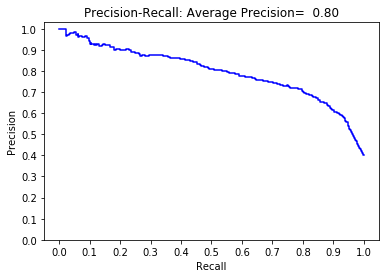

PR-AUC 0.7968851429520107


In [8]:
plt, pr_auc = create_precision_recall_graph(y_train, y_train_predict_proba[:,1])
plt.show()
print("PR-AUC", pr_auc)

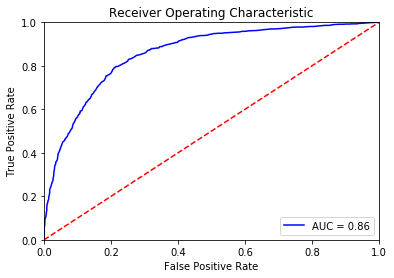

ROC-AUC 0.8580159313309519


In [9]:
plt, roc_auc = create_receiver_operation_characteristic_graph(y_train, y_train_predict_proba[:,1])
plt.show()
print("ROC-AUC", roc_auc)

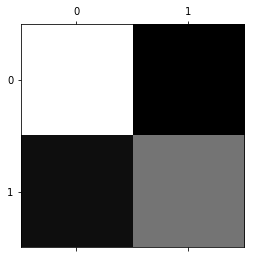

In [10]:
plt = create_error_matrix_graph(y_train, y_train_predict)
plt.show()

## Evaluate classifier on non-undersampled test set

In [11]:
y_predict, y_predict_proba = clf.test_predict()
y = output.y_test

In [12]:
# Evaluate model parameters: Confusion matrix
create_confusion_matrix(y, y_predict)

,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,754,162
True Vandalism,99,227


In [13]:
# Evaluate model parameters: Classification report
print(create_classification_report(y, y_predict))

              precision    recall  f1-score   support

No Vandalism       0.88      0.82      0.85       916
   Vandalism       0.58      0.70      0.63       326

 avg / total       0.81      0.79      0.80      1242



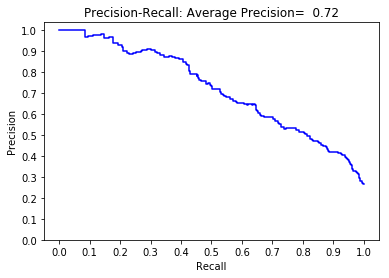

PR-AUC 0.721039333507489


In [14]:
plt, pr_auc = create_precision_recall_graph(y, y_predict_proba[:,1])
plt.show()
print("PR-AUC", pr_auc)

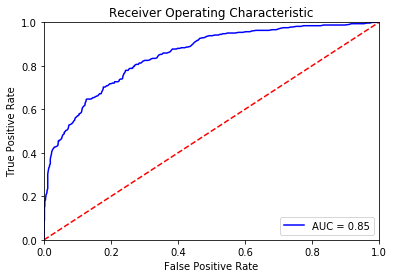

ROC-AUC 0.8499812468186567


In [15]:
plt, roc_auc = create_receiver_operation_characteristic_graph(y, y_predict_proba[:,1])
plt.show()
print("ROC-AUC", roc_auc)

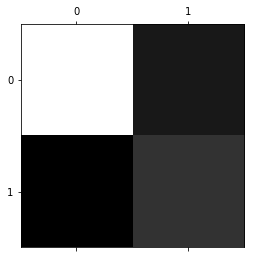

In [16]:
plt = create_error_matrix_graph(y, y_predict)
plt.show()

In [17]:
# False positives
fp = false_positives(output.X_test_with_meta, y, y_predict)
create_revision_link_html(fp, tag_df, 10)

HTML(value='<ul><li>constructive: <a href="http://en.wikipedia.org/index.php?diff=111749758">111749758 </a></l…

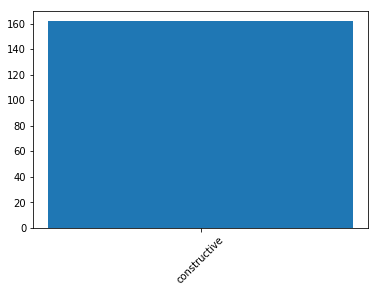

In [18]:
plt = create_revisions_by_tag_graph(fp, tag_df)
plt.show()

In [19]:
# False negatives
fn = false_negatives(output.X_test_with_meta, y, y_predict)
create_revision_link_html(fn, tag_df, 10)

HTML(value='<ul><li>QualityIssue: <a href="http://en.wikipedia.org/index.php?diff=547015023">547015023 </a></l…

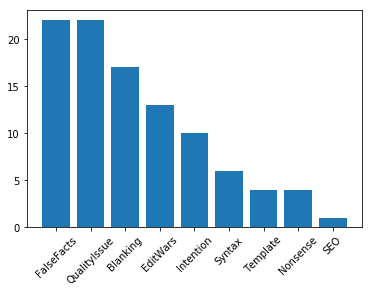

In [20]:
plt = create_revisions_by_tag_graph(fn, tag_df)
plt.show()

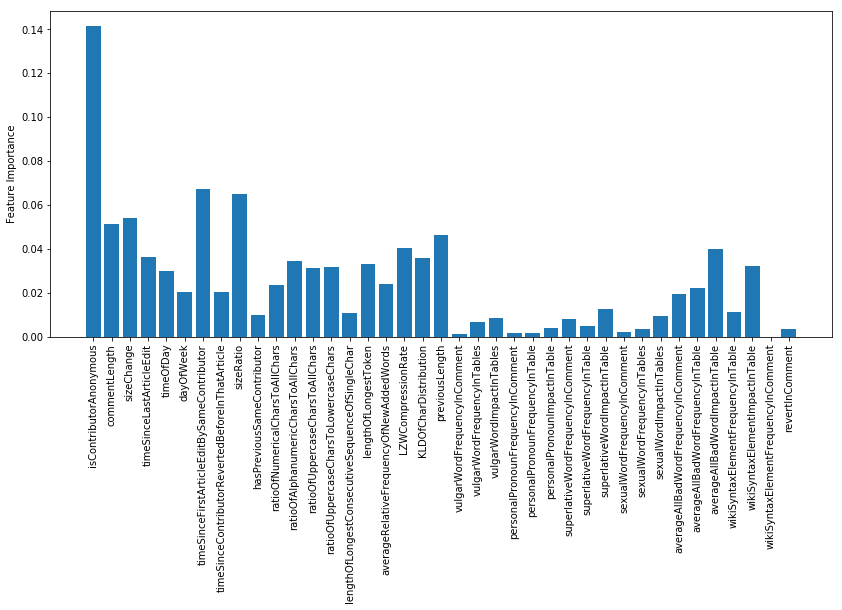

In [21]:
plt = create_feature_importance_graph(clf, output.labels)
plt.show()